In [1]:
# Import required libraries
import numpy as np
import matplotlib.pyplot as plt
import os
import random
import matplotlib.image as mpimg
import tensorflow as tf
from tensorflow.keras import layers, regularizers
from tensorflow.keras.preprocessing import image_dataset_from_directory
from sklearn.metrics import confusion_matrix, classification_report
import seaborn as sns

# Set random seeds for reproducibility
random.seed(42)
np.random.seed(42)
tf.random.set_seed(42)

# Enable CUDA GPU usage for NVIDIA GPUs
gpus = tf.config.list_physical_devices('GPU')
if gpus:
    try:
        # Enable memory growth to avoid allocating all GPU memory at once
        for gpu in gpus:
            tf.config.experimental.set_memory_growth(gpu, True)
        # Optionally restrict to specific GPU: tf.config.set_visible_devices(gpus[0], 'GPU')
        print(f"CUDA enabled: {len(gpus)} GPU(s) available")
    except RuntimeError as e:
        print(f"GPU configuration error: {e}")
else:
    print("No GPU found. Training will use CPU.")

# Check available devices
print("\nTensorFlow version:", tf.__version__)
print("Available devices:")
for device in tf.config.list_physical_devices():
    print(f"  - {device}")

# Enable mixed precision training for faster execution on GPU
# Mixed precision (float16) provides significant speedup on NVIDIA GPUs with Tensor Cores
try:
    policy = tf.keras.mixed_precision.Policy('mixed_float16')
    tf.keras.mixed_precision.set_global_policy(policy)
    print(f'\nMixed precision policy: {policy.name}')
except Exception as e:
    print(f'\nMixed precision not available: {e}')

# Enable XLA (Accelerated Linear Algebra) for faster execution on GPU
try:
    tf.config.optimizer.set_jit(True)
    print('XLA compilation enabled')
except Exception as e:
    print(f'XLA not available: {e}')

print('\nGPU optimizations configured (CUDA + mixed precision + XLA)')

/home/larkhiya/.local/lib/python3.10/site-packages/matplotlib/projections/__init__.py:63: UserWarning: Unable to import Axes3D. This may be due to multiple versions of Matplotlib being installed (e.g. as a system package and as a pip package). As a result, the 3D projection is not available.
  warnings.warn("Unable to import Axes3D. This may be due to multiple versions of "
2026-02-06 19:50:08.860165: I tensorflow/core/util/port.cc:153] oneDNN custom operations are on. You may see slightly different numerical results due to floating-point round-off errors from different computation orders. To turn them off, set the environment variable `TF_ENABLE_ONEDNN_OPTS=0`.
2026-02-06 19:50:09.882706: I tensorflow/core/platform/cpu_feature_guard.cc:210] This TensorFlow binary is optimized to use available CPU instructions in performance-critical operations.
To enable the following instructions: AVX2 AVX_VNNI FMA, in other operations, rebuild TensorFlow with the appropriate compiler flags.
2026-02-

In [2]:
# Define dataset directory paths
dataset_dir = "./archive/"
train_dir = os.path.join(dataset_dir, "train")
test_dir = os.path.join(dataset_dir, "test")

# Log resolved paths
print(f"Dataset train path: {train_dir}")
print(f"Dataset test path: {test_dir}")

# Verify paths exist
for name, path in [("Train", train_dir), ("Test", test_dir)]:
    assert os.path.exists(path), f"{name} directory not found: {path}"

Dataset train path: ./archive/train
Dataset test path: ./archive/test


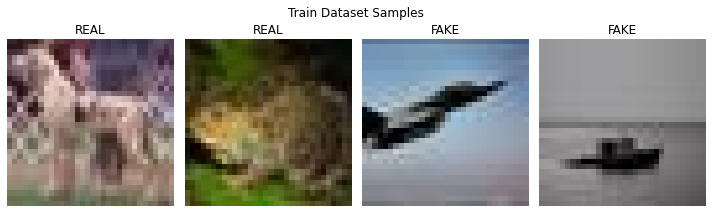

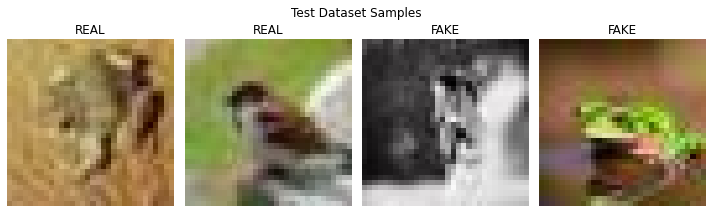

In [3]:
# Display sample images from each class
classes = ['REAL', 'FAKE']

def show_examples(base_dir, title):
    """
    Display sample images from each class in the dataset.
    
    Args:
        base_dir: Base directory containing class subdirectories
        title: Title for the plot
    """
    fig, axes = plt.subplots(1, 4, figsize=(10, 3))
    fig.suptitle(title, fontsize=12)

    for i, cls in enumerate(classes):
        cls_dir = os.path.join(base_dir, cls)
        if not os.path.exists(cls_dir):
            print(f"Warning: Class directory not found: {cls_dir}")
            continue
            
        # Get sample files from each class
        all_files = os.listdir(cls_dir)
        if len(all_files) < 2:
            print(f"Warning: Not enough files in {cls_dir}")
            continue
            
        sample_files = random.sample(all_files, 2)
        for j, img_name in enumerate(sample_files):
            img_path = os.path.join(cls_dir, img_name)
            try:
                img = mpimg.imread(img_path)
                ax = axes[i*2 + j]
                ax.imshow(img)
                ax.set_title(f"{cls}")
                ax.axis('off')
            except Exception as e:
                print(f"Error loading image {img_path}: {e}")

    plt.tight_layout()
    plt.show()

# Display examples from train and test datasets
show_examples(train_dir, "Train Dataset Samples")
show_examples(test_dir, "Test Dataset Samples")

In [4]:
# Image preprocessing configuration
IMG_HEIGHT = 32
IMG_WIDTH = 32
BATCH_SIZE = 64
SEED = 42


def load_training_dataset(
    directory: str,
    img_height: int = IMG_HEIGHT,
    img_width: int = IMG_WIDTH,
    batch_size: int = BATCH_SIZE,
    seed: int = SEED,
):
    """Load training data from the given directory with preset image parameters."""
    return image_dataset_from_directory(
        directory,
        image_size=(img_height, img_width),
        batch_size=batch_size,
        shuffle=True,
        seed=seed,
        label_mode="binary",  # binary classification
    )


# Create training dataset
full_train_ds = load_training_dataset(train_dir)

# Dataset split and pipeline configuration
VAL_SPLIT = 0.1
AUTOTUNE = tf.data.AUTOTUNE  # Automatically determines optimal parallelism


def split_train_val(dataset, val_fraction: float = VAL_SPLIT):
    """Split a dataset into train/validation subsets by batches.

    Returns train_ds, val_ds, total_batches, train_batches, val_batches.
    """
    total_batches = tf.data.experimental.cardinality(dataset).numpy()
    val_batches = int(total_batches * val_fraction)
    train_batches = total_batches - val_batches

    train_ds = dataset.take(train_batches)
    val_ds = dataset.skip(train_batches)

    return train_ds, val_ds, total_batches, train_batches, val_batches


def load_test_dataset(
    directory: str,
    img_height: int = IMG_HEIGHT,
    img_width: int = IMG_WIDTH,
    batch_size: int = BATCH_SIZE,
):
    """Load test data from the given directory (no shuffling)."""
    return image_dataset_from_directory(
        directory,
        image_size=(img_height, img_width),
        batch_size=batch_size,
        shuffle=False,
        label_mode="binary",
    )


def optimize_dataset(dataset, shuffle: bool = False, seed: int | None = None, buffer_size: int = 1000):
    """Apply caching, optional shuffling, and prefetching to a dataset."""
    ds = dataset.cache()
    if shuffle:
        ds = ds.shuffle(buffer_size=buffer_size, seed=seed)
    return ds.prefetch(buffer_size=AUTOTUNE)


def count_images(dataset):
    """Count total number of images in a dataset."""
    return sum(batch[0].shape[0] for batch in dataset)


# Split training data: 90% for training, 10% for validation
train_ds, val_ds, total_batches, train_batches, val_batches = split_train_val(full_train_ds)

# Load test data from test folder (not shuffled or modified)
test_ds = load_test_dataset(test_dir)

# Optimize datasets for maximum performance
train_ds = optimize_dataset(train_ds, shuffle=True, seed=SEED)
val_ds = optimize_dataset(val_ds)
test_ds = optimize_dataset(test_ds)

# Count images in each dataset split
train_count = count_images(train_ds)
val_count = count_images(val_ds)
test_count = count_images(test_ds)

# Print dataset summary
print("Dataset Summary:")
print(f"Total batches in train folder: {total_batches}")
print(f"Train batches (90%): {train_batches}")
print(f"Validation batches (10%): {val_batches}")

print("\nNumber of images:")
print(f"Train images: {train_count}")
print(f"Validation images: {val_count}")
print(f"Test images: {test_count}")


Found 100000 files belonging to 2 classes.
I0000 00:00:1770378669.157609     770 gpu_device.cc:2020] Created device /job:localhost/replica:0/task:0/device:GPU:0 with 3537 MB memory:  -> device: 0, name: NVIDIA GeForce RTX 4050 Laptop GPU, pci bus id: 0000:01:00.0, compute capability: 8.9
Found 20000 files belonging to 2 classes.
2026-02-06 19:51:23.210804: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:453] ShuffleDatasetV3:18: Filling up shuffle buffer (this may take a while): 135 of 1000
2026-02-06 19:51:43.209909: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:453] ShuffleDatasetV3:18: Filling up shuffle buffer (this may take a while): 410 of 1000
2026-02-06 19:51:53.245012: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:453] ShuffleDatasetV3:18: Filling up shuffle buffer (this may take a while): 579 of 1000
2026-02-06 19:52:03.217006: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:453] ShuffleDatasetV3:18: Filling up shuffle buffer (this may take a while): 7

In [5]:
# Data Augmentation (Applied only to training data)
# Augmentation helps improve model generalization by creating variations of training images
# Augmentation is applied on-the-fly (after caching) to ensure variety each epoch
data_augmentation = tf.keras.Sequential([
    layers.RandomFlip("horizontal"),  # Randomly flip images horizontally
    layers.RandomRotation(0.1),       # Randomly rotate images up to 10%
    layers.RandomZoom(0.1),           # Randomly zoom images up to 10%
], name='data_augmentation')

# Apply augmentation efficiently using map with parallel processing
# Augmentation is applied on-the-fly (not cached) to ensure variety each epoch
# This way we cache original images but get different augmentations each time
train_ds = train_ds.map(
    lambda x, y: (data_augmentation(x, training=True), y),
    num_parallel_calls=AUTOTUNE,  # Parallelize augmentation
    deterministic=False  # Allow non-deterministic order for better performance
)
# Re-prefetch after augmentation to maintain pipeline efficiency
train_ds = train_ds.prefetch(buffer_size=AUTOTUNE)


2026-02-06 19:54:45.330587: E tensorflow/core/util/util.cc:131] oneDNN supports DT_HALF only on platforms with AVX-512. Falling back to the default Eigen-based implementation if present.
2026-02-06 19:54:45.517225: I external/local_xla/xla/service/service.cc:163] XLA service 0x7900a40496f0 initialized for platform CUDA (this does not guarantee that XLA will be used). Devices:
2026-02-06 19:54:45.517308: I external/local_xla/xla/service/service.cc:171]   StreamExecutor device (0): NVIDIA GeForce RTX 4050 Laptop GPU, Compute Capability 8.9
2026-02-06 19:54:45.598407: I external/local_xla/xla/stream_executor/cuda/cuda_dnn.cc:473] Loaded cuDNN version 91801
I0000 00:00:1770378886.947285    1003 device_compiler.h:196] Compiled cluster using XLA!  This line is logged at most once for the lifetime of the process.


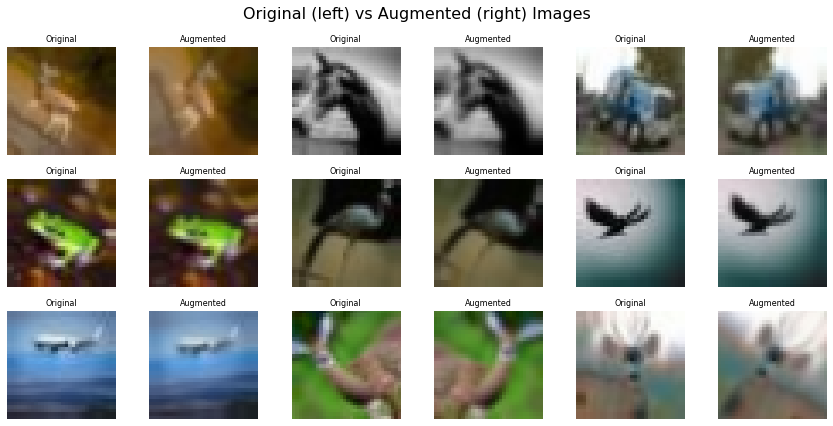

In [6]:
# Visualize original vs augmented images to verify data augmentation is working correctly
for images, labels in train_ds.take(1):
    # Compute augmented batch once
    augmented = data_augmentation(images, training=True)

    plt.figure(figsize=(12, 6))
    for i in range(9):
        # Original image
        plt.subplot(3, 6, 2 * i + 1)
        plt.imshow(tf.cast(images[i], tf.uint8))
        plt.title("Original", fontsize=8)
        plt.axis("off")

        # Augmented image
        plt.subplot(3, 6, 2 * i + 2)
        plt.imshow(tf.cast(augmented[i], tf.uint8))
        plt.title("Augmented", fontsize=8)
        plt.axis("off")

    plt.suptitle("Original (left) vs Augmented (right) Images", fontsize=16)
    plt.tight_layout()
    plt.show()
    break  # Only show one batch

In [7]:
# Fix SSL certificate verification on macOS (required for Keras weight downloads)
import ssl
ssl._create_default_https_context = ssl._create_unverified_context

In [9]:
# Load ResNet50 base model with ImageNet pre-trained weights
# Weights are downloaded automatically by Keras
base_model = tf.keras.applications.ResNet50(
    include_top=False,
    weights='imagenet',
    input_shape=(IMG_HEIGHT, IMG_WIDTH, 3),
    pooling='avg'  # Changed to 'avg' for better performance
)

print("ResNet50 base model loaded with weights: imagenet")

ResNet50 base model loaded with weights: imagenet


In [10]:
# Build the complete model architecture
# Make base model trainable for fine-tuning
base_model.trainable = True

# Define input layer
inputs = tf.keras.Input(shape=(IMG_HEIGHT, IMG_WIDTH, 3))

# Pass input through base ResNet50 model
x = base_model(inputs, training=False)

# Add batch normalization for stable training
x = layers.BatchNormalization()(x)

# Add dense layers with regularization to prevent overfitting
x = layers.Dense(256, activation='relu', kernel_regularizer=regularizers.l2(0.01))(x)
x = layers.Dropout(0.4)(x)  # Dropout for regularization
x = layers.Dense(64, activation='relu')(x)

# Output layer: single neuron with sigmoid activation for binary classification
# Use float32 for output layer (required for mixed precision)
outputs = layers.Dense(1, activation='sigmoid', dtype='float32')(x)

# Create the complete model
model = tf.keras.Model(inputs, outputs)

# Compile model with optimizer, loss function, and metrics
# Using Adam optimizer with learning rate scheduling
model.compile(
    optimizer=tf.keras.optimizers.Adam(learning_rate=0.001),
    loss='binary_crossentropy',  # Binary cross-entropy for binary classification
    metrics=[
        'accuracy',
        tf.keras.metrics.Precision(),  # Precision metric
        tf.keras.metrics.Recall()      # Recall metric
    ]
)

# Display model architecture summary
model.summary()


Model: "functional_1"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ input_layer_2 (InputLayer)      │ (None, 32, 32, 3)      │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ resnet50 (Functional)           │ (None, 2048)           │    23,587,712 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization             │ (None, 2048)           │         8,192 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense (Dense)                   │ (None, 256)            │       524,544 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout (Dropout)               │ (None, 256)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_1 (Dense)                 │ (None, 64)             │        16,448 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_2 (Dense)                 │ (None, 1)              │            65 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 24,136,961 (92.08 MB)

 Trainable params: 24,079,745 (91.86 MB)

 Non-trainable params: 57,216 (223.50 KB)

In [11]:
# Training with callbacks for better performance and convergence

# EarlyStopping: Stop training if validation loss doesn't improve
early_stop = tf.keras.callbacks.EarlyStopping(
    monitor='val_loss',           # Monitor validation loss
    patience=20,                  # Wait 20 epochs before stopping
    restore_best_weights=True,     # Restore weights from best epoch
    verbose=1
)

# ReduceLROnPlateau: Reduce learning rate when validation loss plateaus
# This helps fine-tune the model and improve convergence
reduce_lr = tf.keras.callbacks.ReduceLROnPlateau(
    monitor='val_loss',           # Monitor validation loss
    factor=0.5,                   # Reduce LR by 50%
    patience=5,                   # Wait 5 epochs
    min_lr=1e-7,                  # Minimum learning rate
    verbose=1
)

# ModelCheckpoint: Save best model weights during training
# This ensures we always have the best model even if training continues
os.makedirs('./models', exist_ok=True)
checkpoint_path = './models/best_model_weights.h5'
model_checkpoint = tf.keras.callbacks.ModelCheckpoint(
    checkpoint_path,
    monitor='val_loss',           # Monitor validation loss
    save_best_only=True,          # Only save best model
    save_weights_only=False,     # Save entire model
    verbose=1
)

# Train the model with all callbacks
# Note: train_ds is already shuffled and cached
history = model.fit(
    train_ds,                     # Training dataset (already optimized)
    validation_data=val_ds,       # Validation dataset
    epochs=100,                   # Maximum number of epochs
    callbacks=[early_stop, reduce_lr, model_checkpoint],  # All callbacks
    verbose=1                     # Show training progress
)

Epoch 1/100


2026-02-06 19:57:44.141033: I tensorflow/compiler/mlir/tensorflow/utils/dump_mlir_util.cc:269] disabling MLIR crash reproducer, set env var `MLIR_CRASH_REPRODUCER_DIRECTORY` to enable.
2026-02-06 19:57:57.930433: I external/local_xla/xla/service/gpu/autotuning/dot_search_space.cc:208] All configs were filtered out because none of them sufficiently match the hints. Maybe the hints set does not contain a good representative set of valid configs? Working around this by using the full hints set instead.
2026-02-06 19:57:57.930541: I external/local_xla/xla/service/gpu/autotuning/dot_search_space.cc:208] All configs were filtered out because none of them sufficiently match the hints. Maybe the hints set does not contain a good representative set of valid configs? Working around this by using the full hints set instead.
2026-02-06 19:57:57.930686: I external/local_xla/xla/service/gpu/autotuning/dot_search_space.cc:208] All configs were filtered out because none of them sufficiently match the 

1406/1407 ━━━━━━━━━━━━━━━━━━━━ 0s 33ms/step - accuracy: 0.7986 - loss: 1.3517 - precision: 0.8006 - recall: 0.7943

2026-02-06 19:59:52.244275: I external/local_xla/xla/service/gpu/autotuning/dot_search_space.cc:208] All configs were filtered out because none of them sufficiently match the hints. Maybe the hints set does not contain a good representative set of valid configs? Working around this by using the full hints set instead.
2026-02-06 19:59:53.133892: I external/local_xla/xla/stream_executor/cuda/subprocess_compilation.cc:346] ptxas warning : Registers are spilled to local memory in function 'gemm_fusion_dot_1962', 4 bytes spill stores, 4 bytes spill loads

2026-02-06 20:00:05.374427: I external/local_xla/xla/service/gpu/autotuning/dot_search_space.cc:208] All configs were filtered out because none of them sufficiently match the hints. Maybe the hints set does not contain a good representative set of valid configs? Working around this by using the full hints set instead.



Epoch 1: val_loss improved from None to 0.73893, saving model to ./models/best_model_weights.h5


1407/1407 ━━━━━━━━━━━━━━━━━━━━ 197s 57ms/step - accuracy: 0.8334 - loss: 0.6698 - precision: 0.8360 - recall: 0.8304 - val_accuracy: 0.7854 - val_loss: 0.7389 - val_precision: 0.9313 - val_recall: 0.6087 - learning_rate: 0.0010
Epoch 2/100
1407/1407 ━━━━━━━━━━━━━━━━━━━━ 0s 32ms/step - accuracy: 0.8709 - loss: 0.3413 - precision: 0.8743 - recall: 0.8675
Epoch 2: val_loss did not improve from 0.73893
1407/1407 ━━━━━━━━━━━━━━━━━━━━ 47s 33ms/step - accuracy: 0.8810 - loss: 0.3196 - precision: 0.8815 - recall: 0.8810 - val_accuracy: 0.6361 - val_loss: 1.1075 - val_precision: 0.9870 - val_recall: 0.2638 - learning_rate: 0.0010
Epoch 3/100
1406/1407 ━━━━━━━━━━━━━━━━━━━━ 0s 33ms/step - accuracy: 0.8806 - loss: 0.3254 - precision: 0.8796 - recall: 0.8821
Epoch 3: val_loss did not improve from 0.73893
1407/1407 ━━━━━━━━━━━━━━━━━━━━ 49s 35ms/step - accuracy: 0.8871 - loss: 0.3047 - precision: 0.8903 - recall: 0.8836 - val_accuracy: 0.7249 - val_loss: 1.5607 - val_precision: 0.8755 - val_recall: 0

1407/1407 ━━━━━━━━━━━━━━━━━━━━ 54s 38ms/step - accuracy: 0.9023 - loss: 0.2659 - precision: 0.9009 - recall: 0.9045 - val_accuracy: 0.8755 - val_loss: 0.3949 - val_precision: 0.9543 - val_recall: 0.7846 - learning_rate: 0.0010
Epoch 5/100
1407/1407 ━━━━━━━━━━━━━━━━━━━━ 0s 34ms/step - accuracy: 0.9090 - loss: 0.2430 - precision: 0.9085 - recall: 0.9107
Epoch 5: val_loss did not improve from 0.39487
1407/1407 ━━━━━━━━━━━━━━━━━━━━ 50s 35ms/step - accuracy: 0.9098 - loss: 0.2413 - precision: 0.9113 - recall: 0.9083 - val_accuracy: 0.6244 - val_loss: 1.7421 - val_precision: 0.9966 - val_recall: 0.2375 - learning_rate: 0.0010
Epoch 6/100
1406/1407 ━━━━━━━━━━━━━━━━━━━━ 0s 32ms/step - accuracy: 0.9137 - loss: 0.2301 - precision: 0.9116 - recall: 0.9164
Epoch 6: val_loss did not improve from 0.39487
1407/1407 ━━━━━━━━━━━━━━━━━━━━ 47s 33ms/step - accuracy: 0.9141 - loss: 0.2323 - precision: 0.9128 - recall: 0.9162 - val_accuracy: 0.8128 - val_loss: 0.4244 - val_precision: 0.9653 - val_recall: 0.

1407/1407 ━━━━━━━━━━━━━━━━━━━━ 58s 41ms/step - accuracy: 0.9253 - loss: 0.2014 - precision: 0.9236 - recall: 0.9277 - val_accuracy: 0.9104 - val_loss: 0.2510 - val_precision: 0.9135 - val_recall: 0.9034 - learning_rate: 0.0010
Epoch 8/100
1407/1407 ━━━━━━━━━━━━━━━━━━━━ 0s 32ms/step - accuracy: 0.9292 - loss: 0.1860 - precision: 0.9273 - recall: 0.9313
Epoch 8: val_loss did not improve from 0.25099
1407/1407 ━━━━━━━━━━━━━━━━━━━━ 47s 33ms/step - accuracy: 0.9292 - loss: 0.1907 - precision: 0.9274 - recall: 0.9316 - val_accuracy: 0.8754 - val_loss: 0.3133 - val_precision: 0.9575 - val_recall: 0.7815 - learning_rate: 0.0010
Epoch 9/100
1405/1407 ━━━━━━━━━━━━━━━━━━━━ 0s 33ms/step - accuracy: 0.9340 - loss: 0.1753 - precision: 0.9313 - recall: 0.9368
Epoch 9: val_loss did not improve from 0.25099
1407/1407 ━━━━━━━━━━━━━━━━━━━━ 49s 35ms/step - accuracy: 0.9332 - loss: 0.1803 - precision: 0.9322 - recall: 0.9347 - val_accuracy: 0.8752 - val_loss: 0.3267 - val_precision: 0.9818 - val_recall: 0.

1407/1407 ━━━━━━━━━━━━━━━━━━━━ 57s 40ms/step - accuracy: 0.9307 - loss: 0.1988 - precision: 0.9294 - recall: 0.9324 - val_accuracy: 0.9223 - val_loss: 0.2374 - val_precision: 0.9738 - val_recall: 0.8654 - learning_rate: 0.0010
Epoch 13/100
1407/1407 ━━━━━━━━━━━━━━━━━━━━ 0s 33ms/step - accuracy: 0.9444 - loss: 0.1541 - precision: 0.9411 - recall: 0.9486
Epoch 13: val_loss did not improve from 0.23742
1407/1407 ━━━━━━━━━━━━━━━━━━━━ 49s 34ms/step - accuracy: 0.9431 - loss: 0.1589 - precision: 0.9416 - recall: 0.9451 - val_accuracy: 0.8879 - val_loss: 0.2910 - val_precision: 0.9919 - val_recall: 0.7784 - learning_rate: 0.0010
Epoch 14/100
1406/1407 ━━━━━━━━━━━━━━━━━━━━ 0s 39ms/step - accuracy: 0.9364 - loss: 0.1758 - precision: 0.9350 - recall: 0.9375
Epoch 14: val_loss did not improve from 0.23742
1407/1407 ━━━━━━━━━━━━━━━━━━━━ 57s 40ms/step - accuracy: 0.9413 - loss: 0.1612 - precision: 0.9404 - recall: 0.9427 - val_accuracy: 0.8463 - val_loss: 0.3654 - val_precision: 0.9706 - val_recall

1407/1407 ━━━━━━━━━━━━━━━━━━━━ 62s 44ms/step - accuracy: 0.9663 - loss: 0.0963 - precision: 0.9669 - recall: 0.9659 - val_accuracy: 0.9449 - val_loss: 0.1575 - val_precision: 0.9747 - val_recall: 0.9118 - learning_rate: 5.0000e-04
Epoch 22/100
1407/1407 ━━━━━━━━━━━━━━━━━━━━ 0s 37ms/step - accuracy: 0.9692 - loss: 0.0870 - precision: 0.9681 - recall: 0.9707
Epoch 22: val_loss did not improve from 0.15746
1407/1407 ━━━━━━━━━━━━━━━━━━━━ 55s 39ms/step - accuracy: 0.9683 - loss: 0.0878 - precision: 0.9675 - recall: 0.9693 - val_accuracy: 0.9175 - val_loss: 0.2649 - val_precision: 0.9873 - val_recall: 0.8432 - learning_rate: 5.0000e-04
Epoch 23/100
1407/1407 ━━━━━━━━━━━━━━━━━━━━ 0s 35ms/step - accuracy: 0.9700 - loss: 0.0824 - precision: 0.9696 - recall: 0.9705
Epoch 23: val_loss did not improve from 0.15746
1407/1407 ━━━━━━━━━━━━━━━━━━━━ 52s 37ms/step - accuracy: 0.9696 - loss: 0.0843 - precision: 0.9696 - recall: 0.9698 - val_accuracy: 0.8915 - val_loss: 0.3380 - val_precision: 0.9940 - va

1407/1407 ━━━━━━━━━━━━━━━━━━━━ 73s 51ms/step - accuracy: 0.9855 - loss: 0.0395 - precision: 0.9849 - recall: 0.9862 - val_accuracy: 0.9584 - val_loss: 0.1497 - val_precision: 0.9694 - val_recall: 0.9453 - learning_rate: 1.2500e-04
Epoch 36/100
1406/1407 ━━━━━━━━━━━━━━━━━━━━ 0s 40ms/step - accuracy: 0.9880 - loss: 0.0349 - precision: 0.9877 - recall: 0.9882
Epoch 36: val_loss did not improve from 0.14968
1407/1407 ━━━━━━━━━━━━━━━━━━━━ 59s 41ms/step - accuracy: 0.9875 - loss: 0.0365 - precision: 0.9872 - recall: 0.9879 - val_accuracy: 0.9401 - val_loss: 0.2267 - val_precision: 0.9884 - val_recall: 0.8887 - learning_rate: 1.2500e-04
Epoch 37/100
1407/1407 ━━━━━━━━━━━━━━━━━━━━ 0s 41ms/step - accuracy: 0.9870 - loss: 0.0372 - precision: 0.9867 - recall: 0.9872
Epoch 37: val_loss did not improve from 0.14968
1407/1407 ━━━━━━━━━━━━━━━━━━━━ 60s 42ms/step - accuracy: 0.9870 - loss: 0.0365 - precision: 0.9872 - recall: 0.9869 - val_accuracy: 0.9510 - val_loss: 0.1733 - val_precision: 0.9773 - va

1407/1407 ━━━━━━━━━━━━━━━━━━━━ 0s 45ms/step - accuracy: 0.9927 - loss: 0.0214 - precision: 0.9919 - recall: 0.9936
Epoch 52: val_loss did not improve from 0.14968
1407/1407 ━━━━━━━━━━━━━━━━━━━━ 67s 48ms/step - accuracy: 0.9927 - loss: 0.0212 - precision: 0.9923 - recall: 0.9932 - val_accuracy: 0.9536 - val_loss: 0.1871 - val_precision: 0.9768 - val_recall: 0.9277 - learning_rate: 1.5625e-05
Epoch 53/100
1406/1407 ━━━━━━━━━━━━━━━━━━━━ 0s 41ms/step - accuracy: 0.9926 - loss: 0.0218 - precision: 0.9921 - recall: 0.9932
Epoch 53: val_loss did not improve from 0.14968
1407/1407 ━━━━━━━━━━━━━━━━━━━━ 61s 43ms/step - accuracy: 0.9923 - loss: 0.0221 - precision: 0.9920 - recall: 0.9926 - val_accuracy: 0.9522 - val_loss: 0.1896 - val_precision: 0.9769 - val_recall: 0.9246 - learning_rate: 1.5625e-05
Epoch 54/100
1407/1407 ━━━━━━━━━━━━━━━━━━━━ 0s 39ms/step - accuracy: 0.9935 - loss: 0.0190 - precision: 0.9926 - recall: 0.9944
Epoch 54: val_loss did not improve from 0.14968
1407/1407 ━━━━━━━━━━━━━

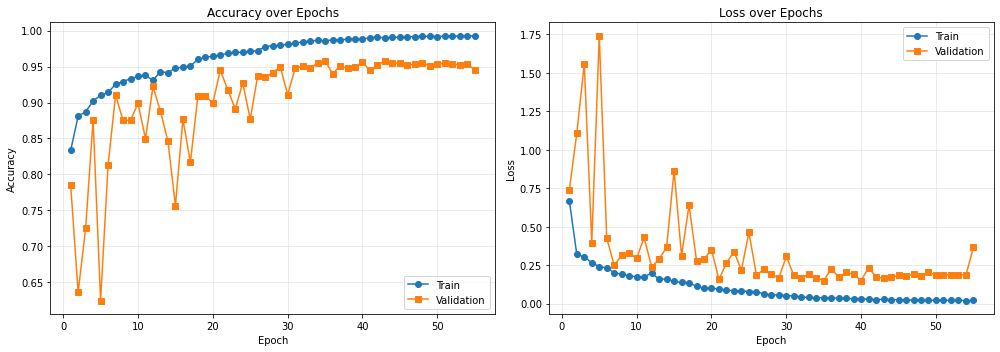

In [12]:
# Plot training history to visualize model performance

def plot_training_history(history):
    """Plot accuracy and loss curves from a Keras History object."""
    epochs = range(1, len(history.history["accuracy"]) + 1)

    plt.figure(figsize=(14, 5))

    # Plot accuracy over epochs
    plt.subplot(1, 2, 1)
    plt.plot(epochs, history.history["accuracy"], label="Train", marker="o")
    plt.plot(epochs, history.history["val_accuracy"], label="Validation", marker="s")
    plt.xlabel("Epoch")
    plt.ylabel("Accuracy")
    plt.title("Accuracy over Epochs")
    plt.grid(True, alpha=0.3)
    plt.legend(loc="lower right")

    # Plot loss over epochs
    plt.subplot(1, 2, 2)
    plt.plot(epochs, history.history["loss"], label="Train", marker="o")
    plt.plot(epochs, history.history["val_loss"], label="Validation", marker="s")
    plt.xlabel("Epoch")
    plt.ylabel("Loss")
    plt.title("Loss over Epochs")
    plt.grid(True, alpha=0.3)
    plt.legend(loc="upper right")

    plt.tight_layout()
    plt.show()


plot_training_history(history)

313/313 ━━━━━━━━━━━━━━━━━━━━ 6s 20ms/step - accuracy: 0.9567 - loss: 0.1573 - precision: 0.9714 - recall: 0.9412

Test Results:
Test Accuracy: 0.9567
Test Precision: 0.9714
Test Recall: 0.9412


2026-02-06 21:01:03.870844: I tensorflow/core/framework/local_rendezvous.cc:407] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
2026-02-06 21:01:15.114086: I external/local_xla/xla/stream_executor/cuda/subprocess_compilation.cc:346] ptxas warning : Registers are spilled to local memory in function 'gemm_fusion_dot_1923', 116 bytes spill stores, 116 bytes spill loads



313/313 ━━━━━━━━━━━━━━━━━━━━ 35s 58ms/step


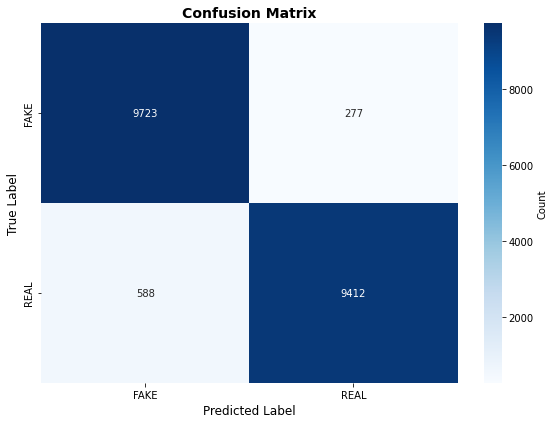


Classification Report:
              precision    recall  f1-score   support

        FAKE       0.94      0.97      0.96     10000
        REAL       0.97      0.94      0.96     10000

    accuracy                           0.96     20000
   macro avg       0.96      0.96      0.96     20000
weighted avg       0.96      0.96      0.96     20000



In [13]:
# Evaluate model performance on test data
test_loss, test_acc, test_prec, test_rec = model.evaluate(test_ds, verbose=1)
print(f"\nTest Results:")
print(f"Test Accuracy: {test_acc:.4f}")
print(f"Test Precision: {test_prec:.4f}")
print(f"Test Recall: {test_rec:.4f}")

# Get true labels from test dataset
y_true = np.concatenate([y for x, y in test_ds], axis=0)

# Get predictions from model
y_pred = model.predict(test_ds, verbose=1)
# Convert probabilities to binary predictions using 0.5 threshold
y_pred_classes = (y_pred.flatten() > 0.5).astype("int32")

# Create and display confusion matrix
cm = confusion_matrix(y_true, y_pred_classes)
plt.figure(figsize=(8, 6))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', 
            xticklabels=['FAKE', 'REAL'], 
            yticklabels=['FAKE', 'REAL'],
            cbar_kws={'label': 'Count'})
plt.xlabel('Predicted Label', fontsize=12)
plt.ylabel('True Label', fontsize=12)
plt.title('Confusion Matrix', fontsize=14, fontweight='bold')
plt.tight_layout()
plt.show()

# Print detailed classification report
print("\nClassification Report:")
print(classification_report(y_true, y_pred_classes, target_names=['FAKE', 'REAL']))


In [14]:
# Save the trained model
os.makedirs('./models', exist_ok=True)
model_save_path = "./models/resnet50_binary.h5"
model.save(model_save_path)
print(f"Model saved successfully to: {model_save_path}")


Model saved successfully to: ./models/resnet50_binary.h5
